In [1]:
import matplotlib.pyplot as plt
from brian2.only import *

# for the IDE:
import numpy_ as np
import spatial, model, inputs, readout

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes


rng = np.random.default_rng(368741)

N = 100
inhibitory_ratio = .2

from conf.params import params
params.update({
    # # Population size
    # 'N': N,
    # 'N_exc': int((1-inhibitory_ratio) * N),
    # 'N_inh': int(inhibitory_ratio * N),

    # Paradigm
    'settling_period': 1*msecond,
    'sequence_length': 5,
    'sequence_count': 10,
    'fully_random_msc': True,
    'fully_random_oddball': True,
    'ISI': 100*ms
})

In [2]:
X, Y, W, D = spatial.create_weights(params, rng)
Xstim, Ystim = spatial.create_stimulus_locations(params)
A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)

Net = model.create_network(X, Y, Xstim, Ystim, W, D, params,
    reset_dt=inputs.get_episode_duration(params), extras=('u', 'xr'),
    state_dt=params['dt'], state_vars=['v', 'u', 'th_adapt', 'synaptic_xr', 'g_exc', 'g_inh'])
rundata = readout.setup_run(Net, params, rng, {'A': A, 'B': B})
Net.run(rundata['runtime'])

readout.get_results(Net, params, rundata);
stimulated_neurons = spatial.get_stimulated(X, Y, Xstim, Ystim, params)[0]

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'Inh', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [ ]:
p = 2
criterion = np.sum(rundata['dynamics'][0]['A']['std']['v'][:params['N_exc'], p] > params['v_threshold'], -1)
criterion[stimulated_neurons[stimulated_neurons<params['N_exc']]] = 0
sorting = np.argsort(-criterion)
for j in sorting[:11]:
    plt.axhline(params['v_threshold'], color='grey')
    plt.plot(rundata['dynamics'][0]['A']['std']['th_adapt'][j, p] + params['v_threshold'])
    plt.plot(rundata['dynamics'][0]['A']['std']['v'][j, p])
    plt.plot(rundata['dynamics'][0]['A']['std']['u'][j, p])
    plt.title(j)
    plt.show()

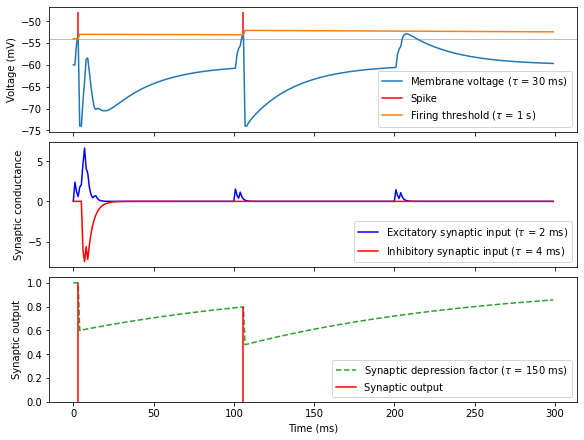

In [23]:
npulses = 3
legend_loc = 'lower right'
for j in sorting[:1]:
    u, v, th_adapt, xr, g_exc, g_inh = [
        np.concatenate([
            rundata['dynamics'][0]['A']['std'][k][j, p]
            for p in range(npulses)], axis=-1)
        for k in ('u','v','th_adapt','xr','g_exc','g_inh')]
    spikes = np.concatenate([
        rundata['spikes'][0]['A']['std']['pulsed_t'][p][rundata['spikes'][0]['A']['std']['pulsed_i'][p]==j] + p*params['ISI']
        for p in range(npulses)])
    time = np.arange(0*second, npulses*params['ISI']-params['dt']/2, params['dt'])

    fig, axs = plt.subplots(3, figsize=(8,6), sharex=True, constrained_layout=True)
    axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
    for spike in spikes:
        axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='r')
    axs[0].plot(time/ms, v/mV, label='Membrane voltage ($\\tau$ = 30 ms)')
    axs[0].plot([], color='r', label='Spike')
    axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold ($\\tau$ = 1 s)')
    axs[0].legend(loc=legend_loc)
    axs[0].set_ylabel('Voltage (mV)')

    axs[1].plot(time/ms, g_exc, label='Excitatory synaptic input ($\\tau$ = 2 ms)', c='b')
    axs[1].plot(time/ms, -g_inh, label='Inhibitory synaptic input ($\\tau$ = 4 ms)', c='r')
    axs[1].legend(loc=legend_loc)
    axs[1].set_ylabel('Synaptic conductance')

    axs[2].plot(time/ms, xr, '--', c='C2', label='Synaptic depression factor ($\\tau$ = 150 ms)')
    axs[2].vlines(spikes/ms, 0, xr[(((spikes+params['dt']/2))/params['dt']).astype(int)], color='r')
    axs[2].plot([], c='r', label='Synaptic output')
    axs[2].set_ylim(bottom=0)
    axs[2].legend(loc=legend_loc)
    axs[2].set_ylabel('Synaptic output')

    plt.xlabel('Time (ms)')

Text(0, 0.5, 'Voltage (mV)')

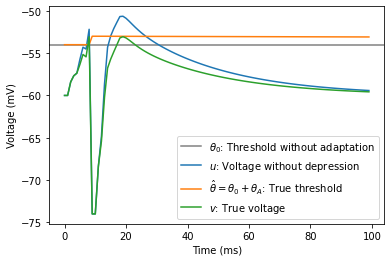

In [14]:
plt.axhline((params['v_threshold'])/mV, color='grey', label='$\\theta_0$: Threshold without adaptation')
plt.plot((u)/mV, label='$u$: Voltage without depression')
plt.plot((th_adapt + params['v_threshold'])/mV, label='$\\hat \\theta = \\theta_0+\\theta_A$: True threshold')
plt.plot((v)/mV, label='$v$: True voltage')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

In [15]:
depression = u-v
threshold = th_adapt
activity = u-params['v_threshold']

Text(0, 0.5, 'Voltage influence')

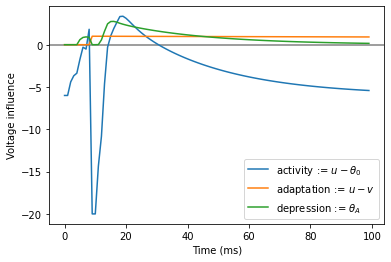

In [16]:
plt.axhline(0, color='grey')
plt.plot(activity/mV, label='activity := $u-\\theta_0$')
plt.plot(threshold/mV, label='adaptation := $u-v$')
plt.plot(depression/mV, label='depression := $\\theta_A$')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage influence')